In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from statsmodels.tsa.arima_model import ARIMA

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import statsmodels
print(statsmodels.__version__)

0.10.1


In [3]:
data_train = pd.read_csv("E:/Python/Datasets/data_train_NNFormat.csv", index_col = 'timestamp')

In [4]:
data_train.head()

,fact
timestamp,
2019-01-01 00:00:00,294.0
2019-01-01 01:00:00,292.0
2019-01-01 02:00:00,290.0
2019-01-01 03:00:00,293.0
2019-01-01 04:00:00,294.0


In [5]:
new_df = data_train[0:len(data_train): 24]

<AxesSubplot:xlabel='timestamp'>

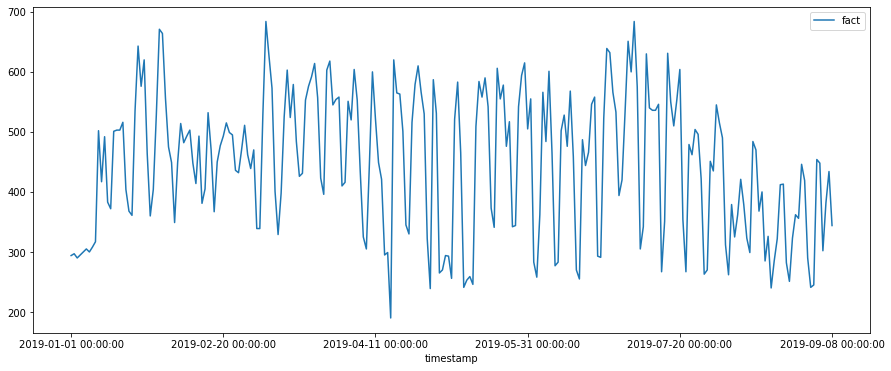

In [6]:
new_df.plot(figsize = (15,6))

In [7]:
data_train = new_df['fact']

In [8]:
data_train = data_train[0:245]

### 2.	Постройте график полученного ряда (ВР).

<AxesSubplot:xlabel='timestamp'>

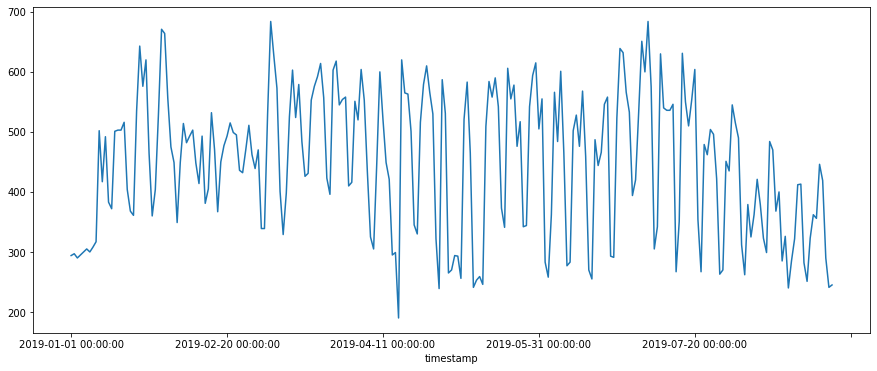

In [9]:
data_train.plot(figsize=(15,6))

### 3.	Осуществите проверку на случайность полученного ряда по обоим известным вам критериям.

**Критерий серий, основанный на медиане выборки**

In [10]:
median = data_train.median()
def plus_minus_median(row):
    if row > median:
        return '+'
    elif row < median:
        return '-'
    else:
        return '0'

In [11]:

def series_test(df):
    n = len(df)
    median = df.median()
    y_plus_minus = df.apply(plus_minus_median).values
    
    
    series = []
    max_series = 0
    k = 1
    for i in range(1,n):
        if (y_plus_minus[i] != y_plus_minus[i-1]):
            
            if k > 0:
                series.append(k)
                if k > max_series:
                    max_series = k
            if (y_plus_minus[i] == '0'):
                k = 0
            else:
                k = 1
        else:
            k += 1
    
    first_cond = len(series) > 0.5 * (n + 1 - 1.96 * (n-1)**(1/2))
    second_cond = max_series < 3.3 * np.log(n+1)
    return first_cond, second_cond
    

In [12]:
series_test(data_train)

(False, True)

**Вывод:** Только один из условий критерия выполняются, следовательно отклоняем гипотезу случайности, значит данные не случайны, присутстует тренд.

**Критерий "восходящих и нисходящих" серий**

In [13]:
def plus_minus_zero(row):
    if row > 0:
        return '+'
    elif row < 0:
        return '-'
    else:
        return '0'
    
def tay_0(n):
    if n <= 26:
        return 5
    elif 26 < n <= 153:
        return 6
    elif 153 < n <= 1170:
        return 7
    else:
        print('n out of 1170!')
        return 7

In [14]:
def second_test(df):
    

    df_diff = df.diff()
    
    y_plus_minus = df_diff.apply(plus_minus_zero).values
    series = []
    max_series = 0
    k = 1
    n = len(y_plus_minus)
    for i in range(1,n):
        if (y_plus_minus[i] != y_plus_minus[i-1]):
            
            if k > 0:
                series.append(k)
                if k > max_series:
                    max_series = k
            if (y_plus_minus[i] == '0'):
                k = 0
            else:
                k = 1
        else:
            k += 1
            
    firs_cond = len(series) > (1/3)*(2*n - 1) - 1.96*((16*n-29)/90)**(1/2) 
    second_cond = max_series < tay_0(n)
    return firs_cond, second_cond

In [15]:
second_test(data_train)

(False, True)

**Вывод:** Только один из условий критерия выполняются, следовательно отклоняем гипотезу случайности, значит данные не случайны, присутстует тренд.

### 4.	Получите статистическую оценку тренда и сезонной компоненты ВР с помощью МНК. Сравните полученную оценку тренда с трендом.

<AxesSubplot:xlabel='timestamp'>

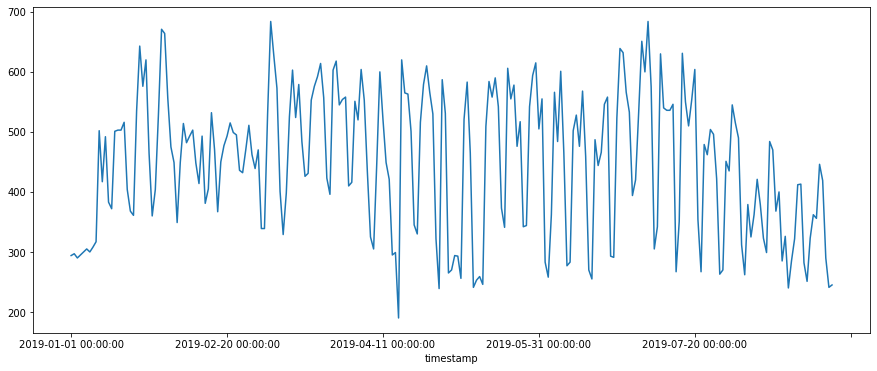

In [16]:
data_train.plot(figsize=(15,6))

**Строим полиномиальную и линейную регрессию**

In [17]:
y = data_train.values

In [18]:
X = np.arange(1, len(y)+1)[:, np.newaxis]

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
regr = LinearRegression()

In [20]:
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [21]:
X_quad[:10]

array([[  1.,   1.,   1.],
       [  1.,   2.,   4.],
       [  1.,   3.,   9.],
       [  1.,   4.,  16.],
       [  1.,   5.,  25.],
       [  1.,   6.,  36.],
       [  1.,   7.,  49.],
       [  1.,   8.,  64.],
       [  1.,   9.,  81.],
       [  1.,  10., 100.]])

In [22]:
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

In [23]:
regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

In [24]:
regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y, regr.predict(X_quad))

In [25]:
regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

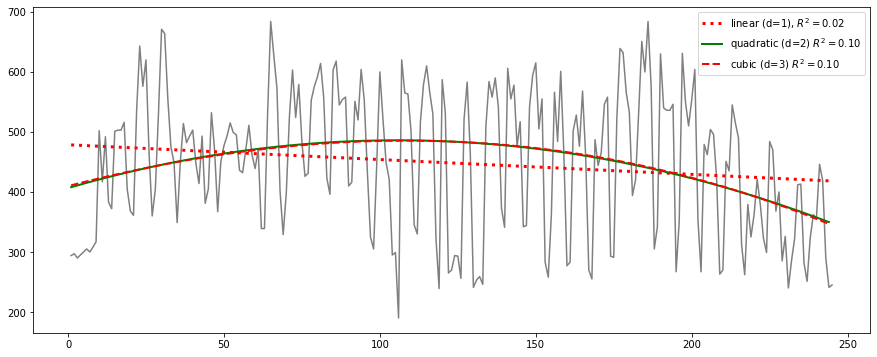

In [26]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_fit, y_lin_fit, 
         color = 'red',
         linestyle = ':',
         lw = 3,
         label = 'linear (d=1), $R^2={:.2f}$'.format(linear_r2))

plt.plot(X_fit, y_quad_fit,
        color = 'green',
        lw = 2,
        linestyle = '-',
        label = 'quadratic (d=2) $R^2={:.2f}$'.format(quad_r2))

plt.plot(X_fit, y_cubic_fit,
        color = 'red',
        lw = 2,
        linestyle = '--',
        label = 'cubic (d=3) $R^2={:.2f}$'.format(cubic_r2))
plt.legend(loc = 'upper right')



Найдём наилучший полином

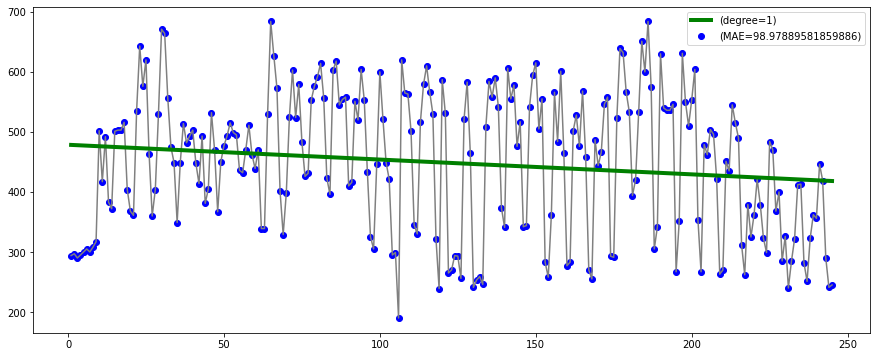

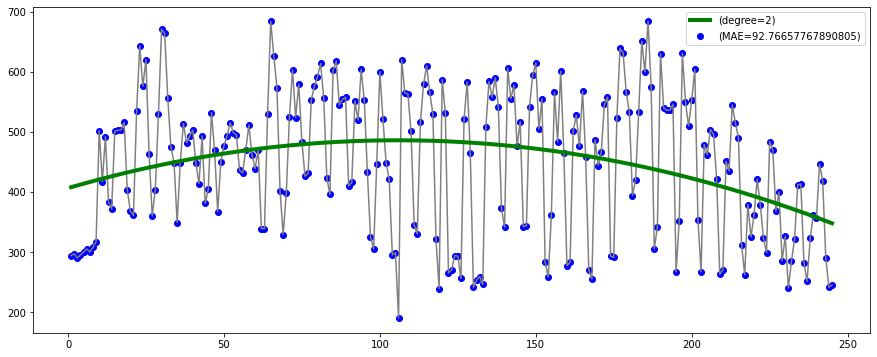

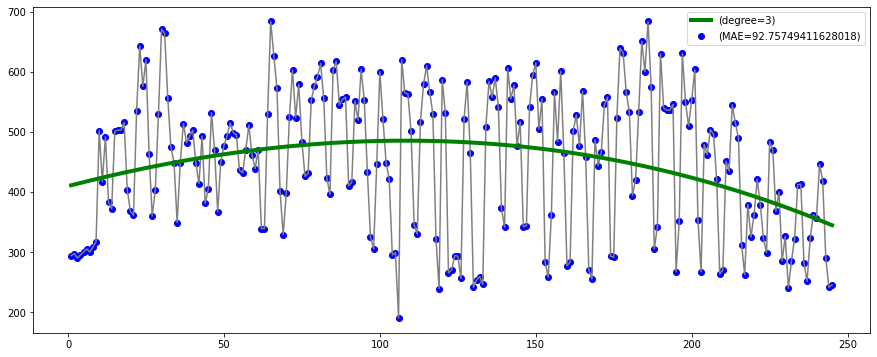

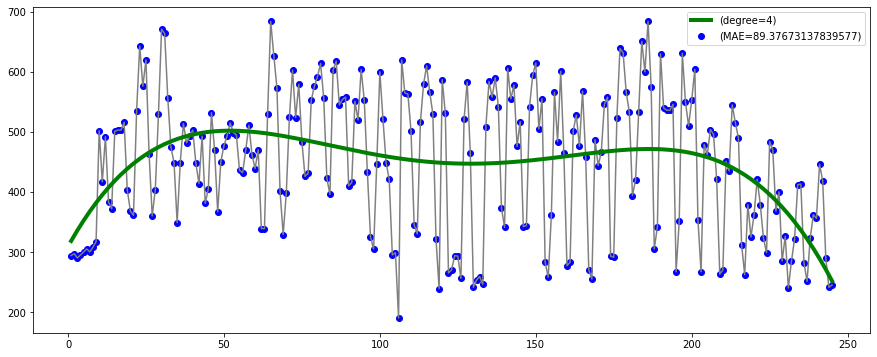

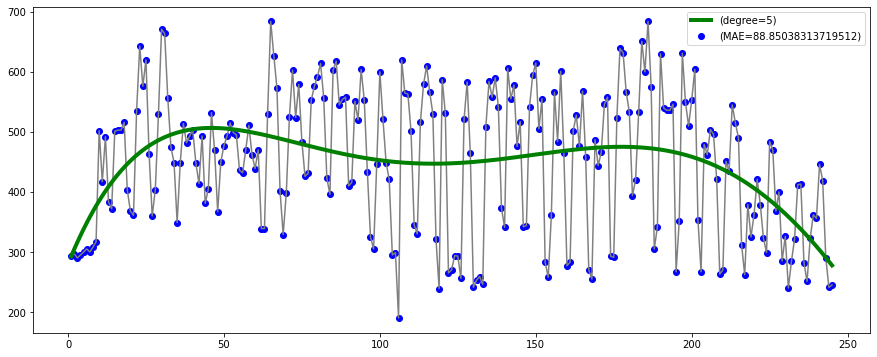

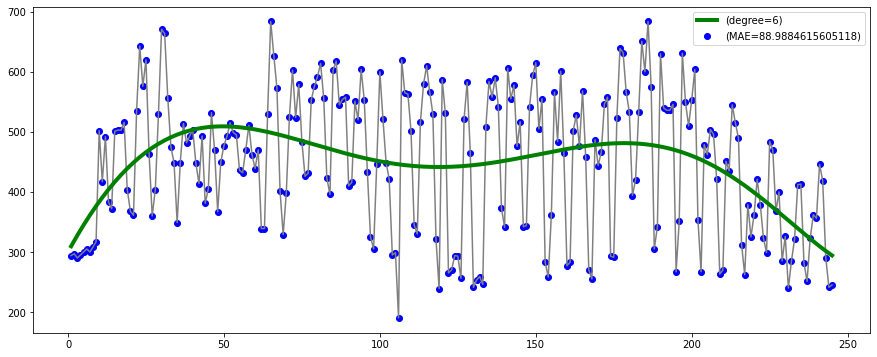

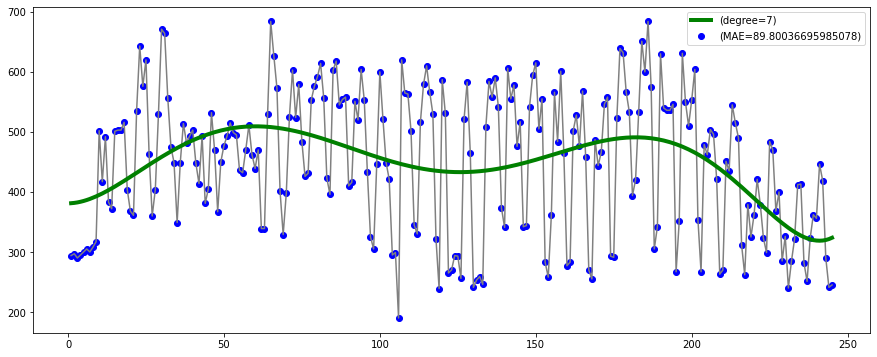

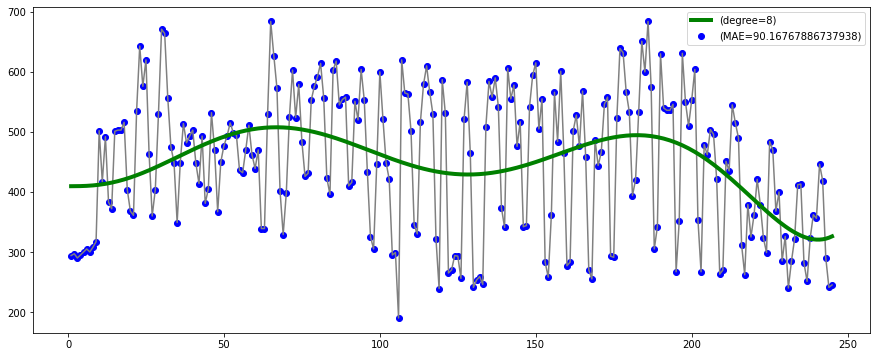

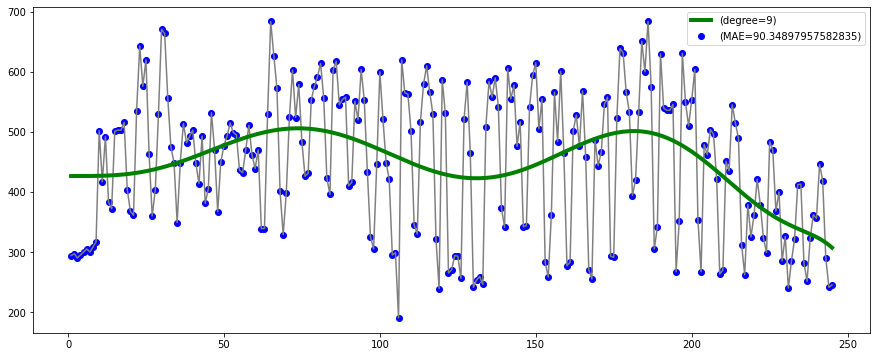

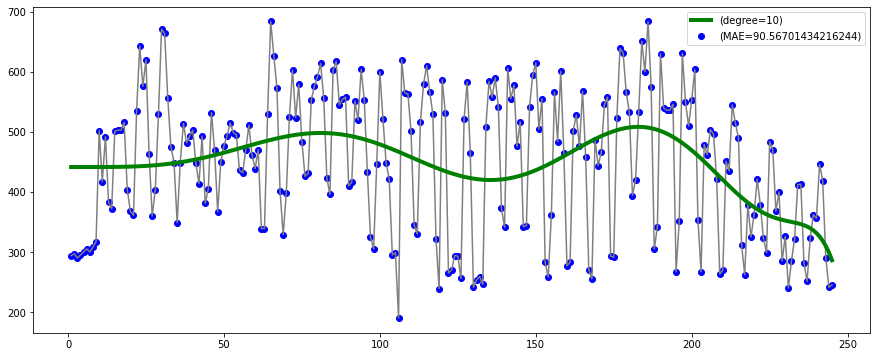

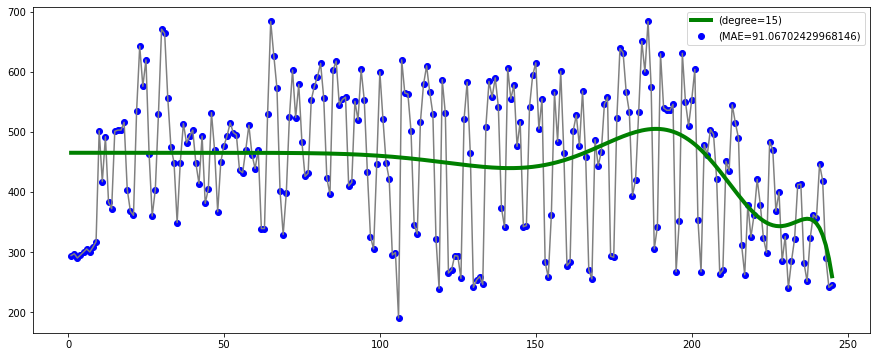

In [27]:
min_MAE = 1000
best_k = 0 
for k in range(1, 20):

    X_fit = X
    quadratic = PolynomialFeatures(degree = k)
    X_quad = quadratic.fit_transform(X)
    regr.fit(X_quad, y)
    y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
    quad_r2 = r2_score(y, regr.predict(X_quad))
    MAE = mean_absolute_error(y, y_quad_fit)
    
    # if MAE < min_MAE:
    if k ==5 :
        min_MAE = MAE
        best_k = k
        best_line = y_quad_fit
    if (k % 5 == 0) or (k < 10):
        plt.figure(figsize=(15,6))
        plt.plot(X, y, color = 'gray')

        plt.scatter(X, y, color = 'b', label = '(MAE={})'.format(MAE))
        plt.plot(X_fit, y_quad_fit,
                color = 'green',
                lw = 4,
                linestyle = '-',
                label = '(degree={})'.format(k))
        plt.legend(loc = 'upper right')

                           

Возьмем наиболее подходяющую модель 

degree = 5
MAE = 88.85038313719512


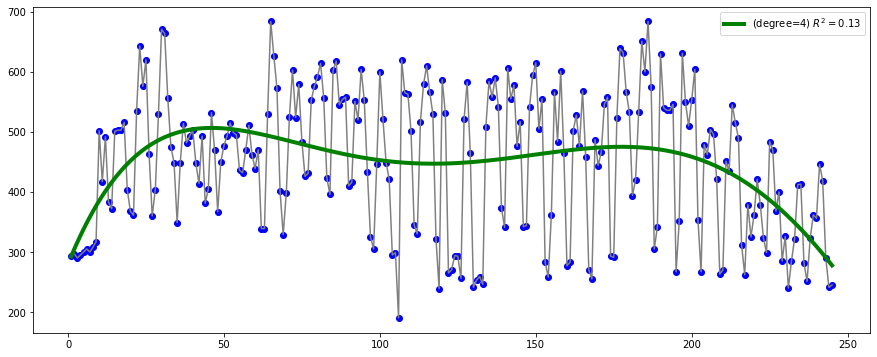

In [28]:

print(f'degree = {best_k}')
print(f'MAE = {min_MAE}')
plt.figure(figsize=(15,6))
plt.plot(X, y, color = 'gray')
plt.scatter(X, y, color = 'b')
plt.plot(X_fit, best_line,
        color = 'green',
        lw = 4,
        linestyle = '-',
        label = '(degree=4) $R^2={:.2f}$'.format(quad_r2))
plt.legend(loc = 'upper right')

In [29]:
X_OLS_trend = X_fit
y_OLS_trend = best_line

Данная ПЛР f(t) = 636.35 -0.055*x  рассматривается как модель тренда <br>


Тренда практически нет, но критерии о случайности ВР говорят что тренд присутсвует

### 5.	Оцените тренд и сезонную компоненту, не используя аналитические предположения о виде сезонной компоненты.

"неаналитический подход (не получая статистическую оценку тренда и периодической компоненты, а используя, например, методику регрессионного анализа)" <br>
Отсюда следует ПЛР со стахостическим градиентным спуском

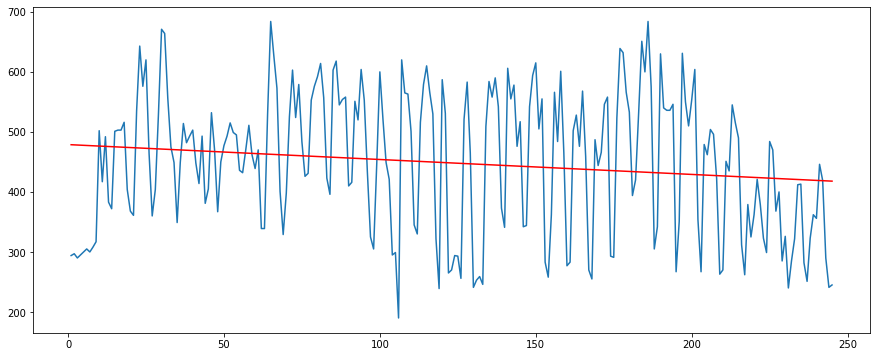

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
model = SGDRegressor()
model.fit(X_scaled,y)
y_pred = model.predict(X_scaled)
plt.figure(figsize=(15,6))
plt.plot(X,y)
plt.plot(X, y_pred, color = 'red')

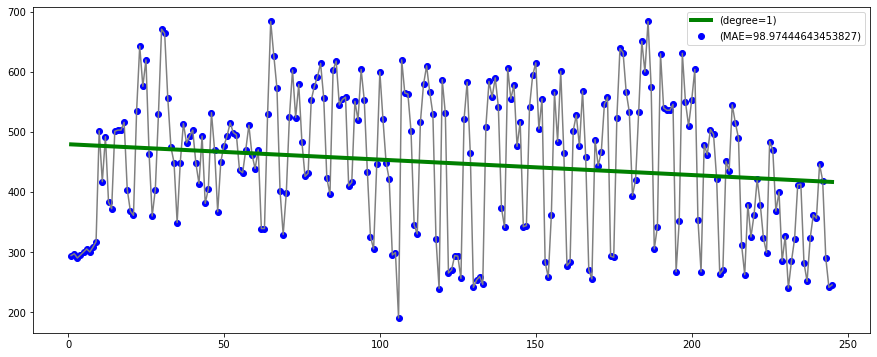

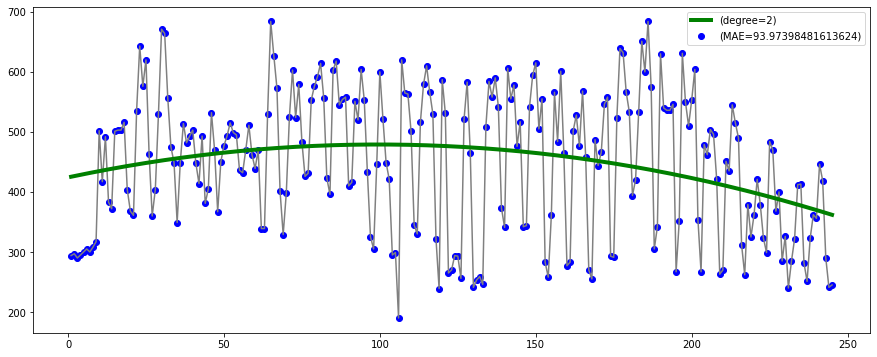

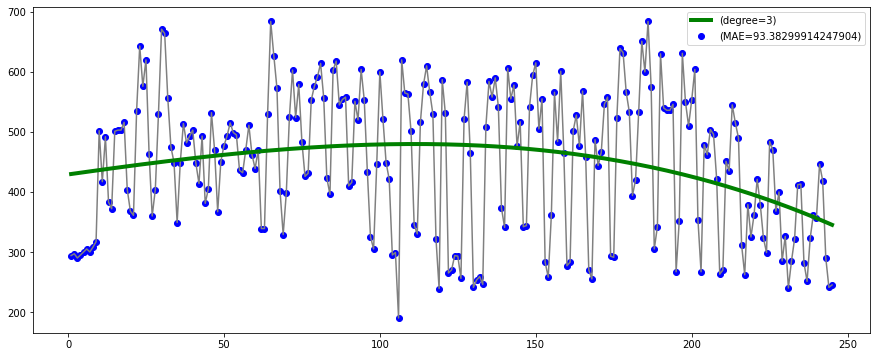

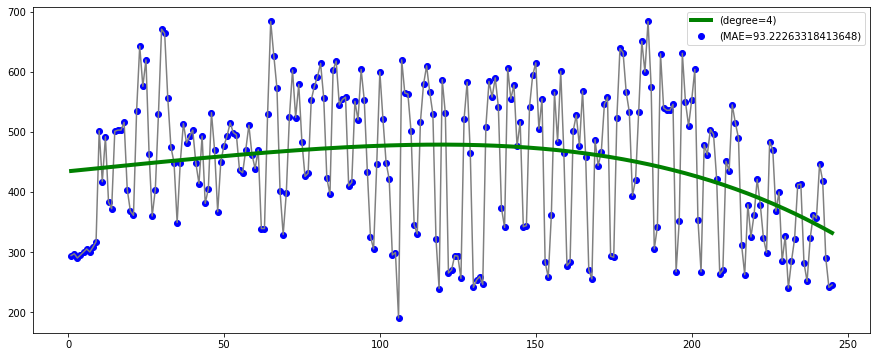

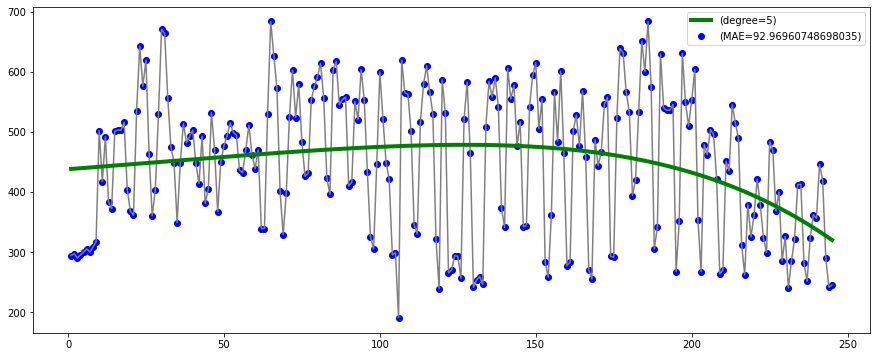

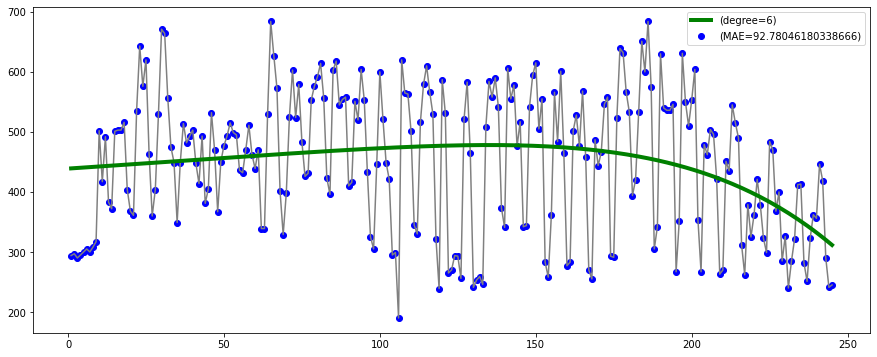

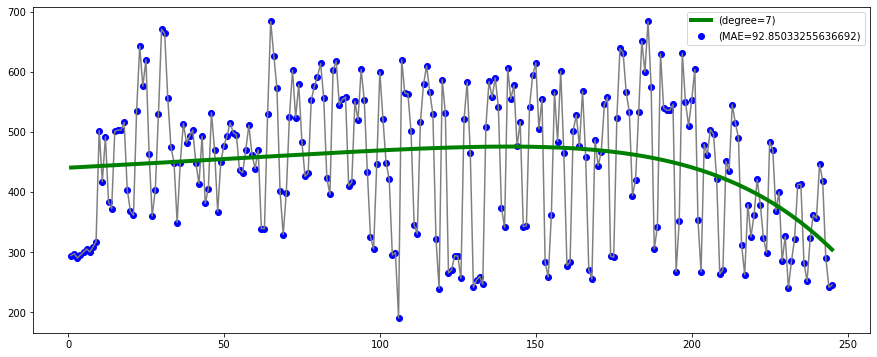

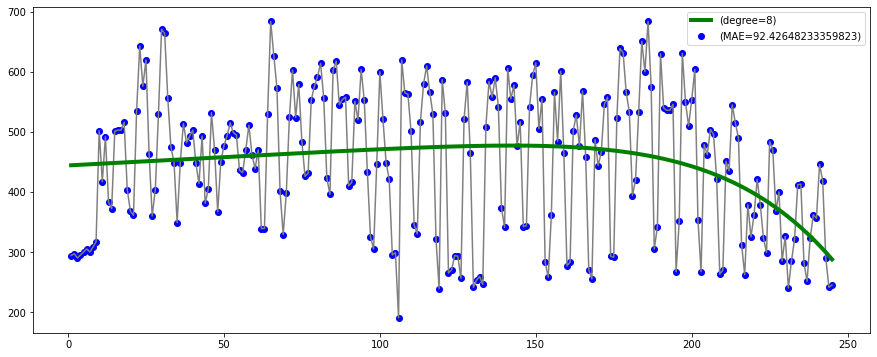

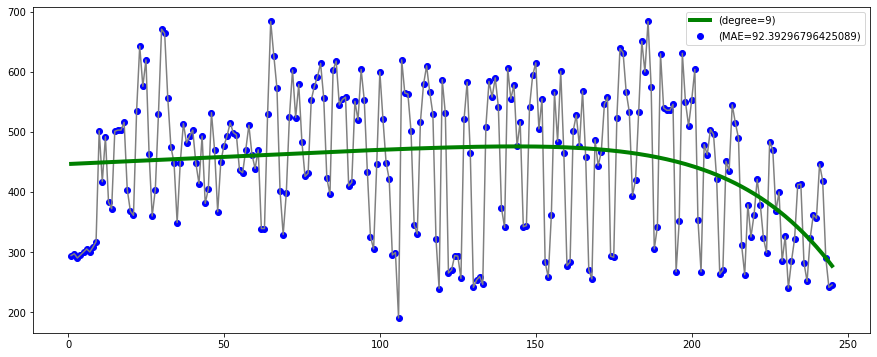

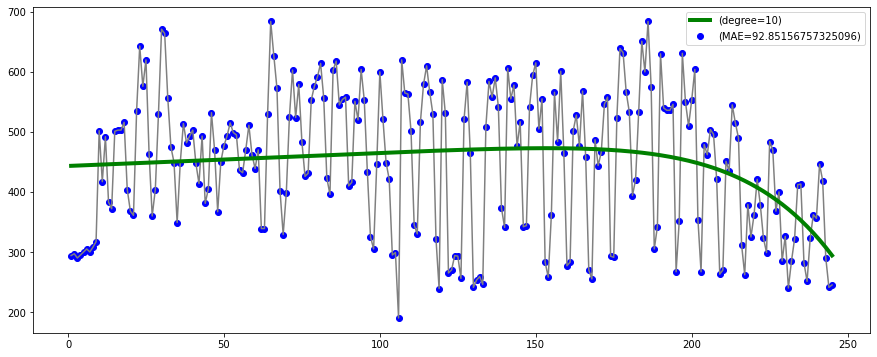

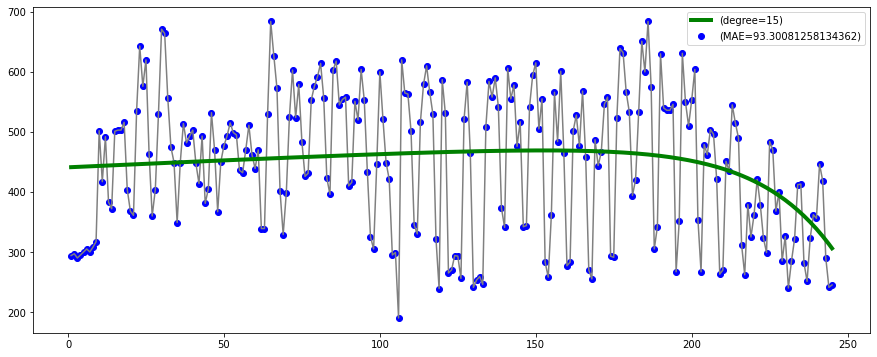

In [31]:
min_MAE = 1000
best_k = 0 
regr = SGDRegressor()
for k in range(1, 20):


    quadratic = PolynomialFeatures(degree = k)
    X_quad = quadratic.fit_transform(X)
    scaler = StandardScaler()
    scaler.fit(X_quad)
    X_quad = scaler.transform(X_quad)
    
    regr.fit(X_quad, y)
    y_quad_fit = regr.predict(X_quad)
    quad_r2 = r2_score(y, regr.predict(X_quad))
    MAE = mean_absolute_error(y, y_quad_fit)
    
    # if MAE < min_MAE:
    if k ==4 :
        min_MAE = MAE
        best_k = k
        best_line = y_quad_fit
    if (k % 5 == 0) or (k < 10):
        plt.figure(figsize=(15,6))
        plt.plot(X, y, color = 'gray')

        plt.scatter(X, y, color = 'b', label = '(MAE={})'.format(MAE))
        plt.plot(X, y_quad_fit,
                color = 'green',
                lw = 4,
                linestyle = '-',
                label = '(degree={})'.format(k))
        plt.legend(loc = 'upper right')

                           

Выберем наиболее подходящий полином

degree = 4
MAE = 93.22263318413648


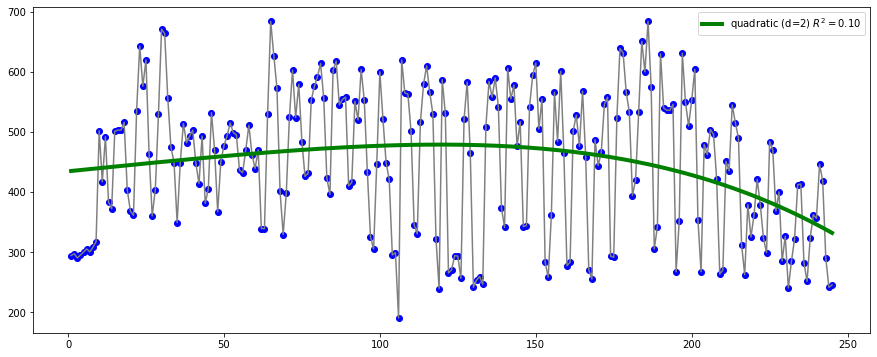

In [32]:

print(f'degree = {best_k}')
print(f'MAE = {min_MAE}')
plt.figure(figsize=(15,6))
plt.plot(X, y, color = 'gray')
plt.scatter(X, y, color = 'b')
plt.plot(X_fit, best_line,
        color = 'green',
        lw = 4,
        linestyle = '-',
        label = 'quadratic (d=2) $R^2={:.2f}$'.format(quad_r2))
plt.legend(loc = 'upper right')

In [33]:
X_SGD_trend = X_fit
y_SGD_trend = best_line

### 6.	Постройте график ВР после процедуры устранения тренда.

#### 1й метод (OLS)

Удаляем тренд: y - f(t)

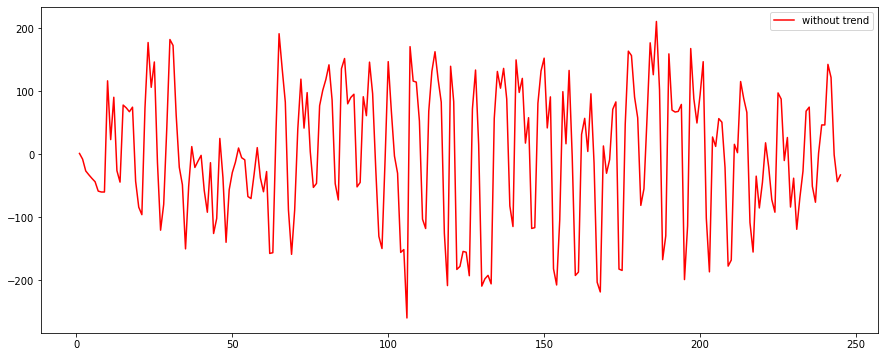

In [34]:
plt.figure(figsize = (15,6))

y_without_trend = y - y_OLS_trend
X = np.arange(1, len(y_without_trend)+1)[:, np.newaxis]

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.legend(loc = 'upper right')

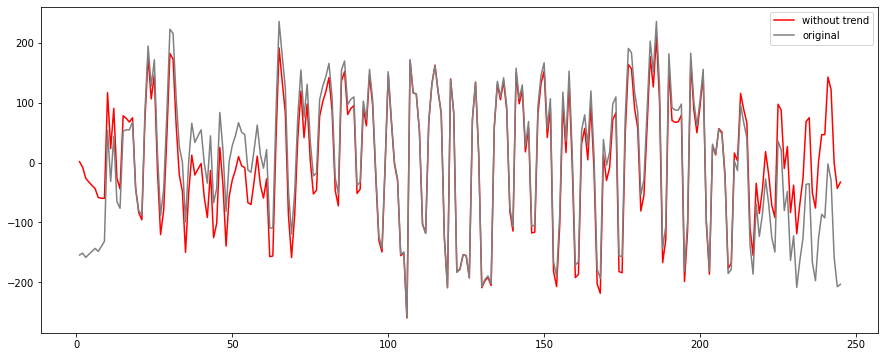

In [35]:
plt.figure(figsize = (15,6))

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.plot(X, y - y.mean(), color = 'gray', label = 'original')

plt.legend(loc = 'upper right')

#### Замечание:
**После удаления тренда из исходного ряда график сдивгается в область нуля** <br>
**Но для сравнения графиков,я исходный график тоже сдвигаю в область нуля (вычиатя срелнее из исходного ряда), чтобы визуально оценить изменения** <br>
**Конечно без сдвига ихсодного ряда, он будет расположен сильно выше**

#### Второй метод (SGD)

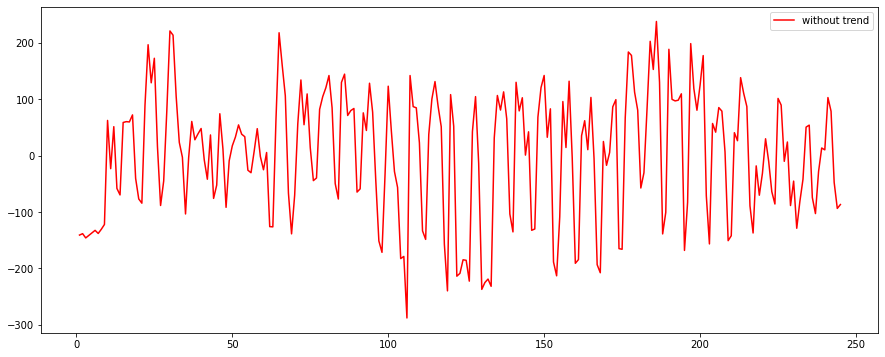

In [36]:
plt.figure(figsize = (15,6))

y_without_trend = y - y_SGD_trend
X = np.arange(1, len(y_without_trend)+1)[:, np.newaxis]

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.legend(loc = 'upper right')

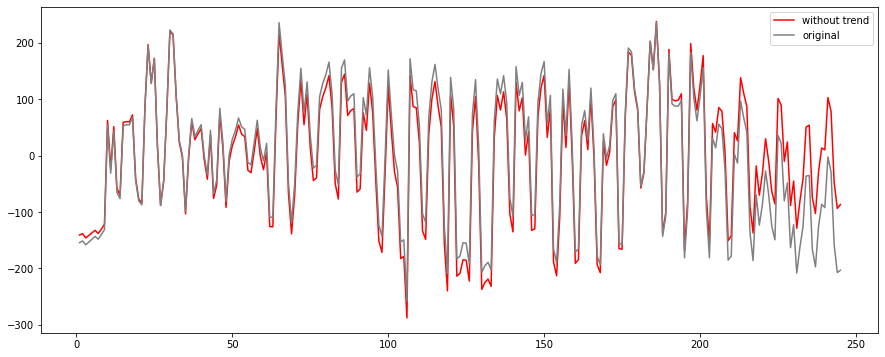

In [37]:
plt.figure(figsize = (15,6))

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.plot(X, y - y.mean(), color = 'gray', label = 'original')

plt.legend(loc = 'upper right')

### 7.	Найдите оценку сезонной компоненты.

#### Первый метод (OLS)

**Оценка сезонной компоненты:**

Период равен неделе: T = 7

In [38]:
n = len(X)
T = 7
m = (n)/(T)
print(f'm = n/T = {m}')

m = n/T = 35.0


Тогда оценка периодической составляющей:

In [39]:
f = y_OLS_trend
S = []
for t in range(0,T):
    sum_value = 0
    for j in range(int(m)):
        sum_value += y[t+j] - f[t+j]
    S.append(sum_value/m)

Text(0.5, 0, 't')

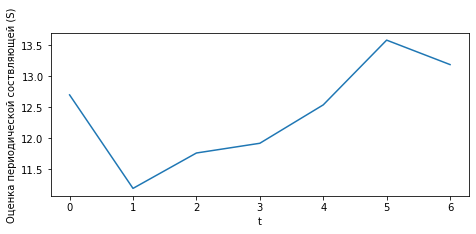

In [40]:
plt.figure(figsize = (7.5,3))
plt.plot(S)
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')

Если сложнить компоненту тренда и сезонную компоненту:
$$ y(t) = u(t) + s(t) $$
То получился следующая модель

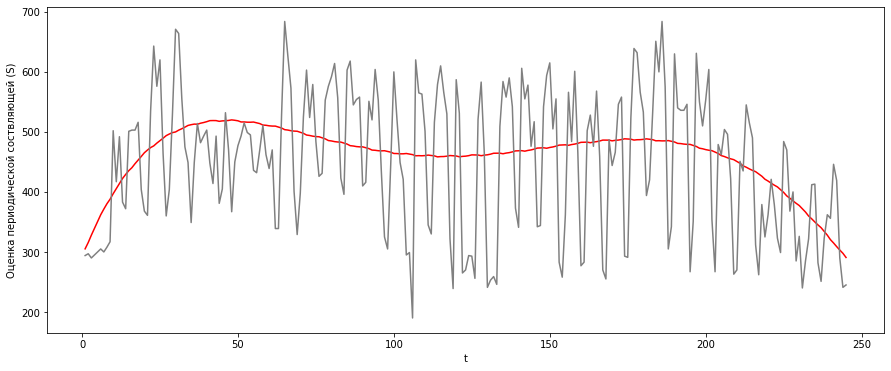

In [41]:
plt.figure(figsize = (15,6))
plt.plot(X, S*int(m) + f, color = 'red', label = 'season')
plt.plot(X, y, color = 'gray', label = 'original')
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')
y_OLS_trend = S*int(m) + f

#### Второй метод (SGD)

Оценка периодической составляющей:

In [42]:
f = y_SGD_trend
S = []
for t in range(0,T):
    sum_value = 0
    for j in range(int(m)):
        sum_value += y[t+j] - f[t+j]
    S.append(sum_value/m)

Text(0.5, 0, 't')

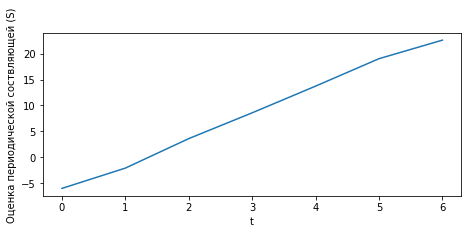

In [43]:
plt.figure(figsize = (7.5,3))
plt.plot(S)
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')

Если сложнить компоненту тренда и сезонную компоненту:
$$ y(t) = u(t) + s(t) $$
То получился следующая модель

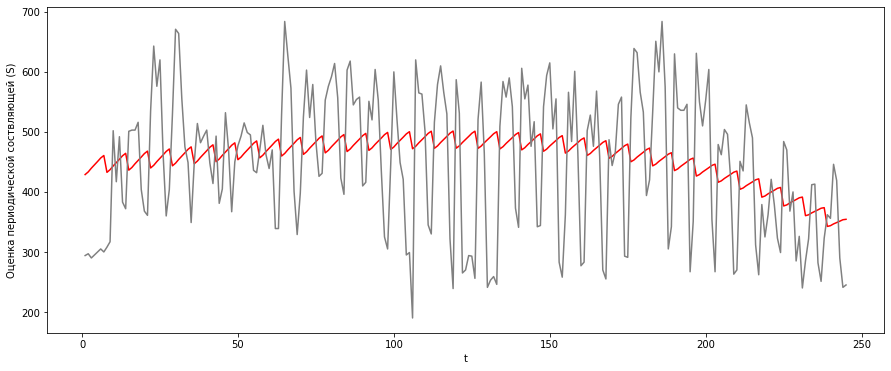

In [44]:
plt.figure(figsize = (15,6))
plt.plot(X, S*int(m) + f, color = 'red', label = 'season')
plt.plot(X, y, color = 'gray', label = 'original')
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')
y_SGD_trend = S*int(m) + f

### 8.	Для каждого из методов оценки тренда и сезонной компоненты вычислите остатки и постройте их графики. Исследуйте остатки на случайность по известным вам критериям. 

#### Первый метод (OLS)

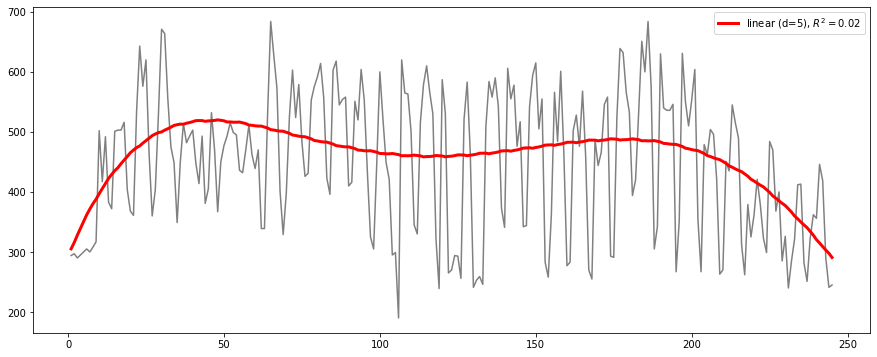

In [45]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_OLS_trend, y_OLS_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')

Text(0, 0.5, 'residuals')

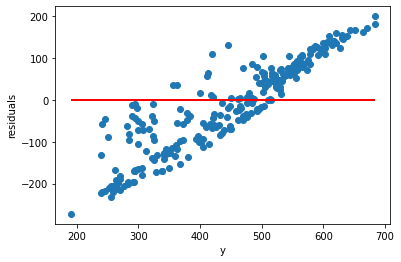

In [46]:
e = y - y_OLS_trend
plt.scatter(y, e)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

Проверим остатки на случаность

Критерий серий основанный на медиане выборки:

In [47]:
e = y - y_OLS_trend
e_series = pd.Series(e)
series_test(e_series)

(False, True)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

 Критерий восходящих и нисходящих серий

In [48]:
second_test(e_series)

(False, False)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Тест Дарбина-Уотсона

In [49]:
from statsmodels.stats.stattools import durbin_watson
print(f'Статистика Дарбина-Уотсона: d = {durbin_watson(e)}')

Статистика Дарбина-Уотсона: d = 1.0680847269437879


In [50]:
n = len(y)
print(f'n = {n}')

n = 245


Alpha = 0.05 <br>
d <= 2 <br>
d_lower = 1.785 <br>
d_upper = 1.801 <br>

Вывод: d < d_lower следовательно нулевая гипотеза о случайности остатков отклоняется <br>
Остатки неслучайны. <br>
Модель тренда неадвекватна. <br>

Делеам вывод, что тренд не выделяется, и модель тренда мы не примаем и не используем

#### Второй метод (SGD)

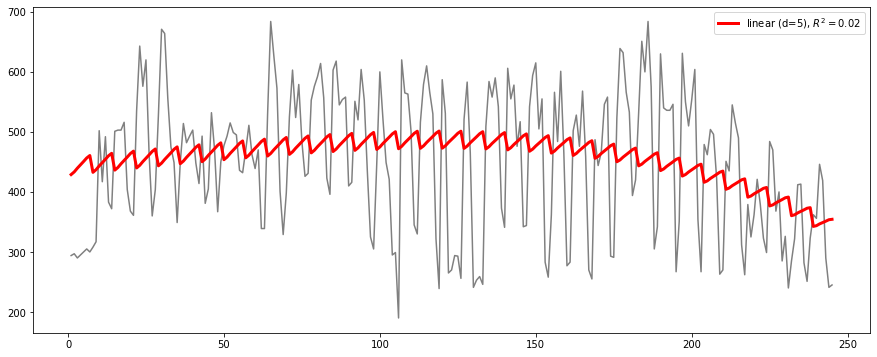

In [51]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_SGD_trend, y_SGD_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')

Text(0, 0.5, 'residuals')

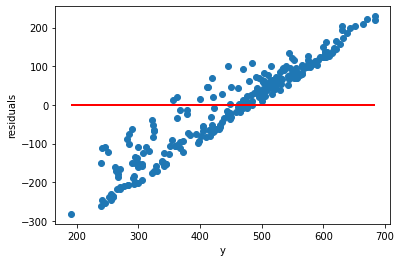

In [52]:
e = y - y_SGD_trend
plt.scatter(y, e)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

Проверим остатки на случаность

Критерий серий основанный на медиане выборки:

In [53]:
e = y - y_OLS_trend
e_series = pd.Series(e)
series_test(e_series)

(False, True)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Критерий восходящих и нисходящих серий

In [54]:
second_test(e_series)

(False, False)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Тест Дарбина-Уотсона

In [55]:
from statsmodels.stats.stattools import durbin_watson
print(f'Статистика Дарбина-Уотсона: d = {durbin_watson(e)}')

Статистика Дарбина-Уотсона: d = 1.0680847269437879


In [56]:
n = len(y)
print(f'n = {n}')

n = 245


Alpha = 0.05 <br>
d <= 2 <br>
d_lower = 1.785 <br>
d_upper = 1.801 <br>

Вывод: d < d_lower следовательно нулевая гипотеза о случайности остатков отклоняется <br>
Остатки неслучайны. <br>
Модель тренда неадвекватна. <br>

Делеам вывод, что тренд не выделяется, и модель тренда мы не примаем и не используем

### 9.	Постройте прогноз исследуемого показателя y для моментов времени t = 31; 34; 37; 41 для каждого из двух рассматриваемых методов. Отметьте полученные прогнозные значения на исходной диаграмме.

#### Первый метод (OLS)

y(31) = 505.2852323234937
y(34) = 512.0229996969139
y(37) = 514.4782207753435
y(41) = 518.9242648406874


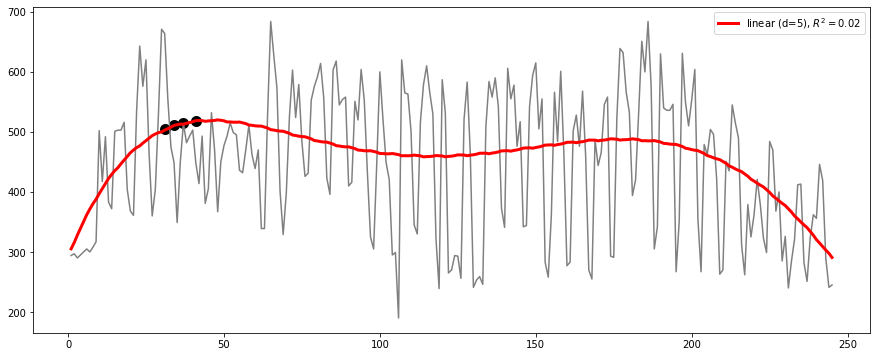

In [57]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_OLS_trend, y_OLS_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')
t = [31, 34, 37, 41]
for i in range(4):
    print(f'y({t[i]}) = {y_OLS_trend[t[i]]}')
plt.scatter(t, y_OLS_trend[t], lw = 5, color = 'black')

#### Второй метод (SGD)

y(31) = 459.57228651437185
y(34) = 475.0753679754514
y(37) = 457.5756368973281
y(41) = 478.49657045267935


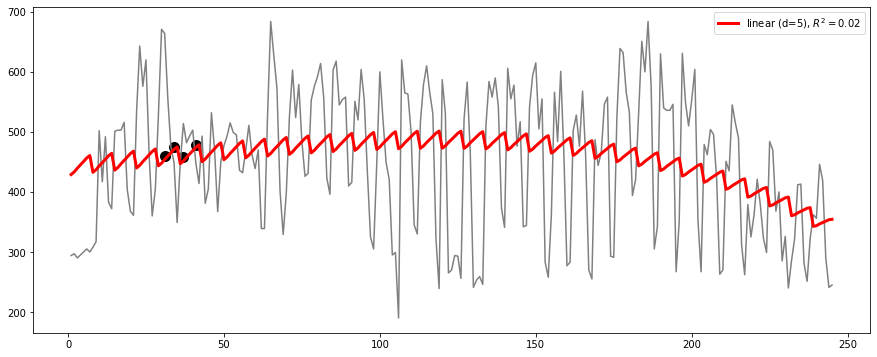

In [58]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_SGD_trend, y_SGD_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')
t = [31, 34, 37, 41]
for i in range(4):
    print(f'y({t[i]}) = {y_SGD_trend[t[i]]}')
plt.scatter(t, y_SGD_trend[t], lw = 5, color = 'black')

### 10.	Проведите сглаживание построенного ВР с помощью метода простой скользящей средней, используя три интервала сглаживания: g = 3, g = 4, g = 5.

In [59]:
y = data_train.values
X = np.arange(1, len(y)+1)[:, np.newaxis]

def moving_average(y, g):
    n = len(y)
    
    y_MA = np.empty(n - (g//2)*2)
    k = 0
    if g%2 == 0:
        p = int(g/2)
        for i in range(0 + p, n - p):
            sum_value = 0
            for j in range(i-p+1, i+p):
                sum_value += y[j]
            sum_value += (y[i-p] + y[i+p])/2
            sum_value = sum_value/(2*p)
            y_MA[k] = sum_value
            k += 1
    else:
        p = int(g//2)
        for i in range(0 + p, n - p):
            sum_value = 0
            for j in range(i-p, i+p+1):
                sum_value += y[j]
            sum_value = sum_value/(2*p + 1)
            y_MA[k] = sum_value
            k += 1
        
    return y_MA

### 11.	На исходной диаграмме ВР постройте графики остатков.

Text(0, 0.5, 'residuals')

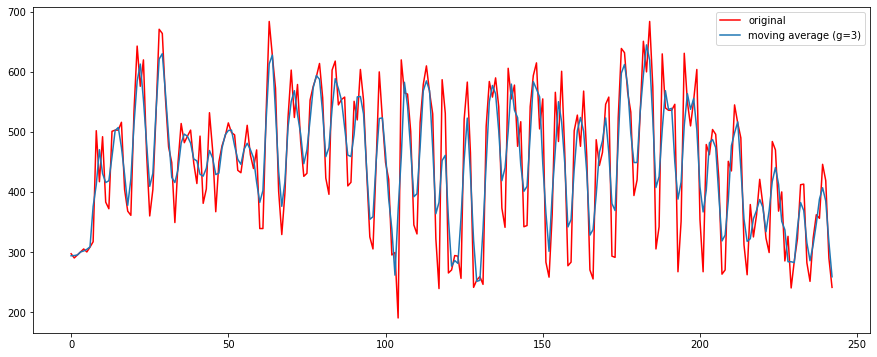

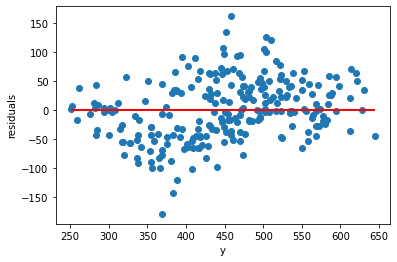

In [60]:
plt.figure(figsize = (15,6))
y_MA_3 = moving_average(y,3)
plt.plot(y[1:-1], color = 'red', label = 'original')
plt.plot(y_MA_3 , label = 'moving average (g=3)')
plt.legend(loc = 'upper right')
y_MA_3_residuals = y[1:-1] - y_MA_3
plt.figure()
plt.scatter(y_MA_3, y_MA_3_residuals)
plt.hlines(xmin=y_MA_3.min(), xmax=y_MA_3.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

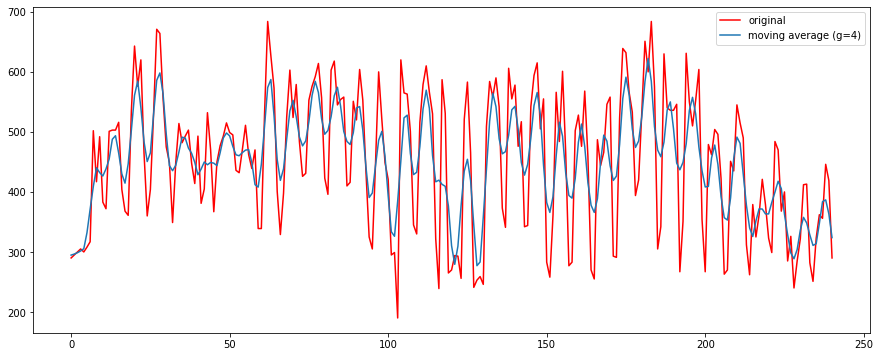

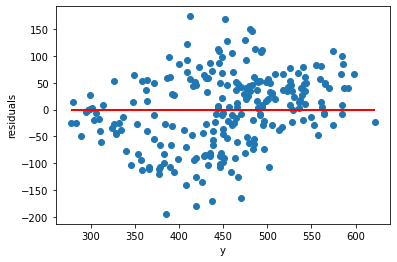

In [61]:
plt.figure(figsize = (15,6))
y_MA_4 = moving_average(y,4)
plt.plot(y[2:-2], color = 'red', label = 'original')
plt.plot(y_MA_4 , label = 'moving average (g=4)')
plt.legend(loc = 'upper right')
y_MA_4_residuals = y[2:-2] - y_MA_4
plt.figure()
plt.scatter(y_MA_4, y_MA_4_residuals)
plt.hlines(xmin=y_MA_4.min(), xmax=y_MA_4.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

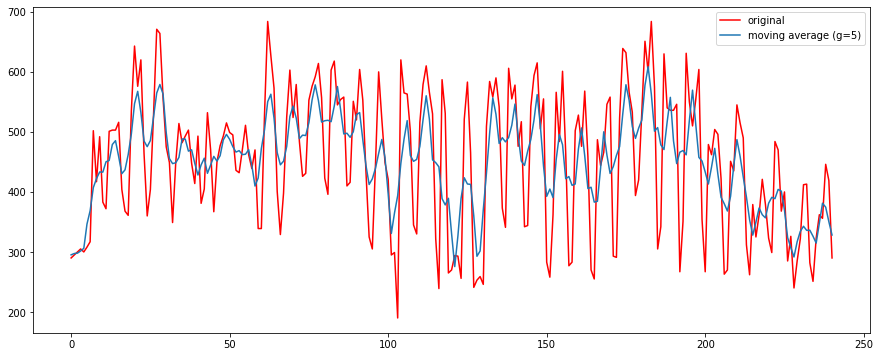

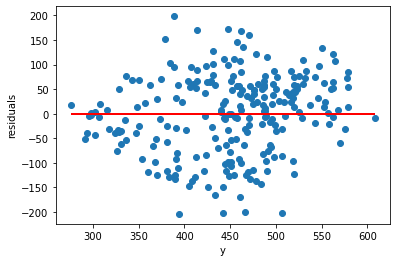

In [62]:
plt.figure(figsize = (15,6))
y_MA_5 = moving_average(y,5)
plt.plot(y[2:-2], color = 'red', label = 'original')
plt.plot(y_MA_5 , label = 'moving average (g=5)')
plt.legend(loc = 'upper right')
y_MA_5_residuals = y[2:-2] - y_MA_5
plt.figure()
plt.scatter(y_MA_5, y_MA_5_residuals)
plt.hlines(xmin=y_MA_5.min(), xmax=y_MA_5.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

### 	12. Смоделируйте двумерную выборку (xi, yi,), состоящую из 48 наблюдений, по формуле
y_i= α+βx_i+u_i,
u_i= ε_i-ρε_(i-1),i=(1,48) ̅, 
где α и β – коэффициенты из вашей первой лабораторной работы, ρ – параметр, выбираемый произвольно в пределах 0,8≤ρ<1,5; ε_i,i=(1,48) ̅ – выборка из нормального распределения N(0,σ^2).


$$ y_{i} = 34.5538 -0.9500 x_{i} + u_{i} $$
$$ u_{i} = \varepsilon_{i} - \varrho \varepsilon_{i-1} $$

In [63]:
import scipy.stats as sts
mu = 0
sigma = 1

# зададим нормально распределенную случайную величину
norm_rv = sts.norm(loc=mu, scale=sigma)
eps = norm_rv.rvs(size=49)
print(eps)

[-0.05721377 -1.07762495  0.67651254  1.8633831   0.79656926 -1.39695658
  0.0460824   1.068753    0.80265355  1.58489692 -0.78103729 -0.22516403
 -0.12573145 -2.16565812  1.07071412 -1.21802722 -1.79710697 -0.62239653
 -0.24664469  1.84576536  1.41841072  1.40827136 -0.51404907  1.0824427
 -0.14359944 -0.7331579   2.40132515  0.36415759 -1.14971171 -0.11498205
 -0.02323792  0.08850633 -0.59924104 -0.12095354 -0.98809268 -0.48538319
  0.5210783   0.1920453  -1.8212126  -0.74479286  0.20596762 -1.05474195
 -0.35646021  0.84381097  0.55139488 -2.30216076  0.55363809 -0.4290788
 -1.10803101]


In [64]:
# Посчитаем u
rho =1.2
u = [eps[i] - rho*eps[i-1] for i in range(1, 49)]
print(f'u = {u}')

u = [-1.0089684226124924, 1.969662484323257, 1.0515680480196887, -1.439490459644266, -2.3528396895358386, 1.722430294695592, 1.0134541178757286, -0.47985005757504573, 0.6217126657279071, -2.6829135925136645, 0.7120807189007273, 0.1444653795857005, -2.014780377194419, 3.669503867111597, -2.5028841688699535, -0.3354743076048161, 1.5341318355478266, 0.5002311464197461, 2.1417389939016394, -0.7965077093688104, -0.29382151325409667, -2.2039746997482554, 1.6993015881388307, -1.4425306778562295, -0.5608385816438077, 3.2811146390399943, -2.5174325982019816, -1.5867008111125256, 1.2646719961768975, 0.11474053933458658, 0.11639184156523645, -0.7054486403286494, 0.5981357100405297, -0.842948432230829, 0.700328025144858, 1.1035381251138678, -0.43324865632603415, -2.0516669641787417, 1.4406622671179654, 1.0997190468772704, -1.3019030945736434, 0.9092301311836999, 1.2715632216298904, -0.46117828348295076, -2.963834622125895, 3.3162310039089795, -1.0934445035791747, -0.5931364562614094]


In [65]:
X = np.arange(1, 49)
y = 34.5538 - 0.95*X + u
print(f'y = {y}')

y = [ 32.59483158  34.62346248  32.75536805  29.31430954  27.45096031
  30.57623029  28.91725412  26.47394994  26.62551267  22.37088641
  24.81588072  23.29826538  20.18901962  24.92330387  17.80091583
  19.01832569  19.93793184  17.95403115  18.64553899  14.75729229
  14.30997849  11.4498253   14.40310159  10.31126932  10.24296142
  13.13491464   6.3863674    6.36709919   8.268472     6.16854054
   5.22019184   3.44835136   3.80193571   1.41085157   2.00412803
   1.45733813  -1.02944866  -3.59786696  -1.05553773  -2.34648095
  -5.69810309  -4.43696987  -5.02463678  -7.70737828 -11.16003462
  -5.829969   -11.1896445  -11.63933646]


In [66]:
len(X)

48

### 13.	Постройте диаграмму рассеяния.

Text(0, 0.5, 'y')

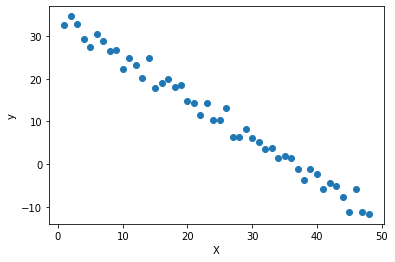

In [67]:
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')

### 14.	Постройте соответствующую парную линейную регрессию и вычислите остатки.

In [68]:
X = X[:,np.newaxis]

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
len(X)

48

a = 34.54291644080399
b = -0.9501248289039398


Text(0, 0.5, 'residuals')

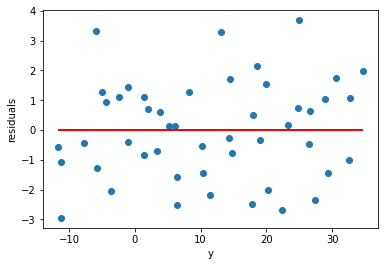

In [71]:
from sklearn.linear_model import LinearRegression
clf_linear = LinearRegression()

clf_linear.fit(X,y)
y_pred = clf_linear.predict(X)
print(f'a = {clf_linear.intercept_}')
print(f'b = {clf_linear.coef_[0]}')
residuals = y - y_pred
plt.scatter(y, residuals)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

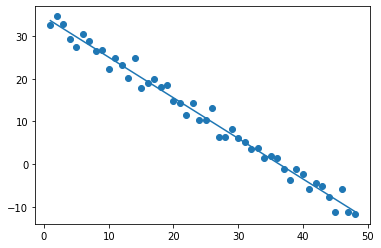

In [72]:
plt.scatter(X, y)
plt.plot(X, y_pred)

In [73]:
mean_absolute_error(y, y_pred)

1.3470454338431577

### 15.	Вычислите статистику Дарбина-Уотсона и сделайте вывод о наличии или отсутствии значимой автокорреляции в остатках, воспользовавшись таблицей критических значений распределения Дарбина-Уотсона. 

In [74]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

2.7644877395354883

In [75]:
4 - durbin_watson(residuals)

1.2355122604645117

In [76]:
n = len(y)
print(f'n = {n}')

n = 48


Alpha = 0.05 <br>
d >= 2 <br>
d_lower = 1.50 <br>
d_upper = 1.50 <br>

Вывод: 4-d < d_lower следовательно нулевая гипотеза о случайности остатков не отклоняется <br>
Значит остатки случайны и автокорреляция отсутвует . <br>

### 16.	Вычислите коэффициент автокорреляции первого порядка и сравните его со значением критерия Дарбина-Уотсона.

In [77]:
print(f'Коэффицеиент авторкорреляции первого порядка = {pd.Series(residuals).autocorr(1)}')

Коэффицеиент авторкорреляции первого порядка = -0.38972304115387235


In [78]:
(1-pd.Series(residuals).autocorr(1))*2

2.7794460823077447

$$ 2[1 - r(e_{t}, e_{t-1})] = 3.380419800222815 $$

$$ 3.298111406151022 \approx 3.380419800222815 $$